### BrainTumorClassifier: InceptionV3-Based Brain Tumor Detection

### **Project Overview**
- **BrainTumorClassifier** is a deep learning project designed to detect **brain tumors** from MRI images, classifying each scan as either **Brain Tumor** or **Healthy**.
- The workflow includes **EDA**, removal of **duplicate images**, **data augmentation**, and **transfer learning** with **InceptionV3**, followed by deployment as an interactive **Streamlit** application and publishing on **Hugging Face**.

### **Objective**
- Develop and deploy a robust **transfer learning model** to support the early detection of **brain tumors**, assisting radiologists and healthcare professionals in making faster, more accurate diagnoses.

### Dataset
- **Source**: [Kaggle – Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset/data)
- **Classes**: Brain Tumor, Healthy
- **Preprocessing**:
    - Duplicate images identified and removed
    - Images resized to **299×299 (RGB)** and normalized
    - Dataset split into **train**, **validation**, and **test** sets with balanced distributions

### **Modeling Approach**
- **Base Model**: **InceptionV3** (pre-trained on ImageNet, fine-tuned for binary classification)
- **Custom Layers**: Batch normalization, dense layer with L1/L2 regularization, dropout for regularization, and a final sigmoid output
- **Training Setup**: Binary crossentropy loss, Adamax optimizer, early stopping, model checkpointing, and learning rate reduction
- **Data Augmentation**: Rotation, width/height shift, and zoom to improve generalization

### **Performance**
- The final model demonstrated excellent performance on the test set:
   - `Accuracy`: 98.04%
   - `Precision`: 97.62%
   - `Recall`: 98.09%
   - `F1 Score`: 97.85%

A **brain tumor** is an abnormal growth of cells within the brain or central nervous system.

These growths can be **benign (non-cancerous)** or **malignant (cancerous)** and may develop in different regions of the brain, potentially affecting vital functions like movement, speech, memory, and balance.

Common **symptoms** may include:
- Persistent or severe headaches
- Vision or hearing problems
- Seizures
- Changes in memory, mood, or personality
- Difficulty with speech or movement

**Risk factors** can involve:
- Genetic predisposition
- Exposure to ionizing radiation
- Weakened immune system
- Family history of brain tumors

Early detection is critical. **MRI scans** are the standard imaging technique to identify and monitor brain tumors.

With prompt diagnosis and appropriate treatment—such as **surgery, radiation therapy, or chemotherapy**—many patients can achieve improved outcomes and quality of life.

### Import Necessary Libraries

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import hashlib
import random
from PIL import Image
import itertools
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam , Adamax  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
# Since the InceptionV3 model was trained on the ImageNet dataset, which uses images preprocessed in a specific way, we need to preprocess our input image so that it matches the format of the images used during the model’s training.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.models import load_model
from huggingface_hub import login
from huggingface_hub import HfApi
from huggingface_hub import hf_hub_download
import warnings 
warnings.filterwarnings("ignore")

2025-10-01 19:41:40.016782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759347700.214647      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759347700.273719      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset Loading

In [ ]:
base_dir = "/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set" # this is the path that contains our data and in this path we have 2 subfolders the first one is called Brain Tumor which contains all the Brain Tumor images and the second subfolder is called Health and this folder contains all the Healty Images

valid_exts = [".jpg", ".jpeg", ".png", ".tif"] # these are the valid type of files or images 

unexpected_files = []

for root, _, files in os.walk(base_dir):
    for f in files: 
        if not any(f.lower().endswith(ext) for ext in valid_exts): 
            unexpected_files.append(os.path.join(root, f)) 

if unexpected_files: 
    print("⚠️ Found files with unexpected extensions:") 
    for uf in unexpected_files: 
        print(uf)
else: 
    print("✅ All files are valid image types")

✅ All files are valid image types


In [ ]:
def is_image_file(filename): 
    return any(filename.lower().endswith(ext) for ext in valid_exts)

image_paths = [] 
image_labels = [] 

for class_name in os.listdir(base_dir): 
    class_path = os.path.join(base_dir, class_name) 

    if not os.path.isdir(class_path): 
        continue
    for image_file in os.listdir(class_path): 
        if is_image_file(image_file): 
            full_path = os.path.join(class_path, image_file) 
            image_paths.append(full_path) 
            image_labels.append(class_name) 


df = pd.DataFrame({"image_path": image_paths, "label": image_labels})

print(f"✅ Total valid images: {len(df)}")
df.head() 

✅ Total valid images: 4600


image_path        label
0  /kaggle/input/brian-tumor-dataset/Brain Tumor ...  Brain Tumor
1  /kaggle/input/brian-tumor-dataset/Brain Tumor ...  Brain Tumor
2  /kaggle/input/brian-tumor-dataset/Brain Tumor ...  Brain Tumor
3  /kaggle/input/brian-tumor-dataset/Brain Tumor ...  Brain Tumor
4  /kaggle/input/brian-tumor-dataset/Brain Tumor ...  Brain Tumor

Data Exploration and Visualization

In [ ]:
df["label"].value_counts()

label
Brain Tumor    2513
Healthy        2087
Name: count, dtype: int64

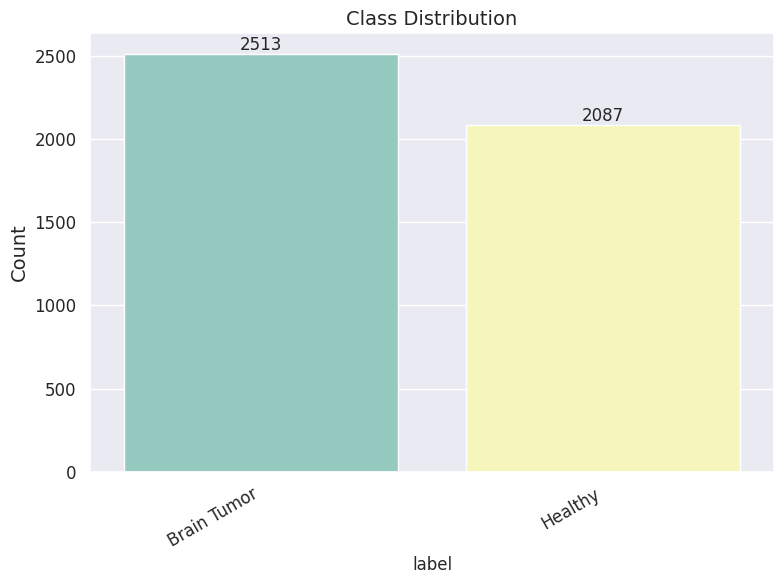

In [10]:
plt.figure(figsize=(8, 6))  

ax = sns.countplot(data=df, x='label', palette='Set3')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"
    )


plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=14)

plt.tight_layout()
plt.show()
# Create a bar plot of the label column to visualize the class distribution, annotate each bar with its count, and format the plot with custom labels, font sizes, and rotation for better readability.

### Duplicate Image Detection

In [11]:
def find_duplicates_in_df(df):
    """Find duplicate images in a DataFrame using MD5 hashes."""
    hashes = {}
    duplicates = []

    for row in df.itertuples():
        image_path = row.image_path
        label = row.label

        try:
            with open(image_path, "rb") as f:
                img_hash = hashlib.md5(f.read()).hexdigest()
                if img_hash in hashes:
                    duplicates.append((label, image_path, hashes[img_hash]))
                else:
                    hashes[img_hash] = image_path
        except Exception as e:
            print(f"⚠️ Error processing {image_path}: {e}")

    df_duplicates = pd.DataFrame(
        duplicates,
        columns=["Label", "Duplicate Path", "Original Path"]
    )

    print(f"✅ Found {len(df_duplicates)} duplicates in dataset")
    return df_duplicates


def display_duplicate_images(df_duplicates, max_samples=5):  
    """Display a few duplicate/original pairs."""
    if df_duplicates.empty:
        print("No duplicates to display.")
        return

    num_samples = min(len(df_duplicates), max_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

    for i, row in enumerate(df_duplicates.iloc[:num_samples].itertuples()):
        try:
            original = Image.open(row._3)  
            duplicate = Image.open(row._2) 

            axes[i, 0].imshow(original, cmap="gray")
            axes[i, 0].set_title(f"Original ({row.Label})")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(duplicate, cmap="gray")
            axes[i, 1].set_title("Duplicate")
            axes[i, 1].axis("off")

        except Exception as e:
            print(f"⚠️ Error displaying images: {e}")

    plt.tight_layout()
    plt.show()

# Detect duplicate images in a DataFrame by computing MD5 hashes, store their paths along with labels, and optionally display a few pairs of original and duplicate images side by side.

✅ Found 544 duplicates in dataset


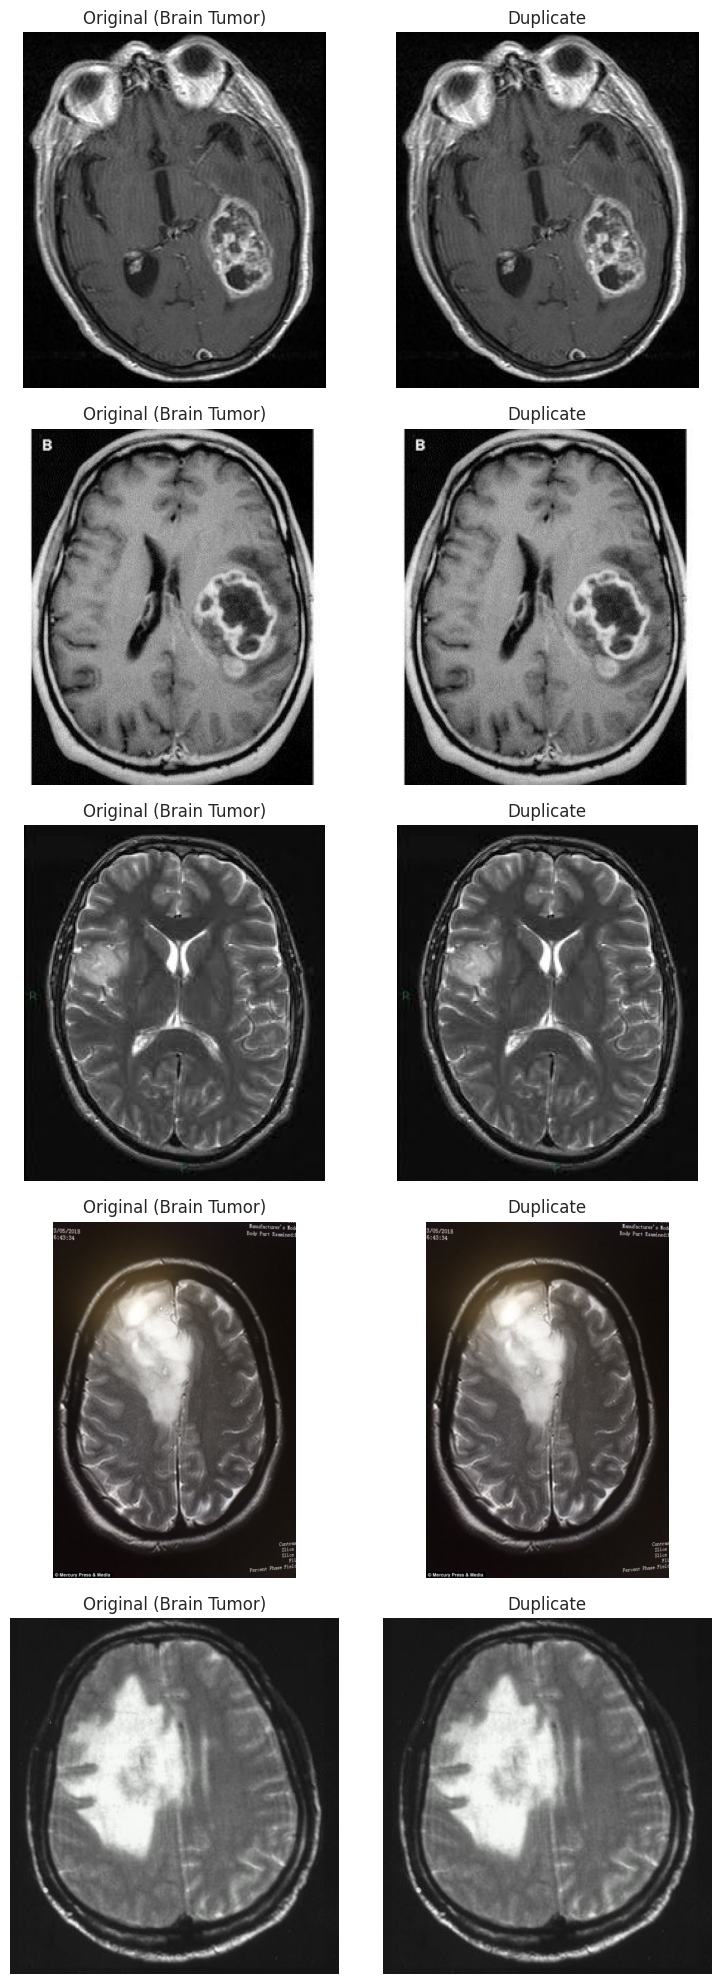

In [12]:
df_duplicates = find_duplicates_in_df(df)

display_duplicate_images(df_duplicates, max_samples=5)

Handling Duplicate Images

In [13]:
def find_duplicates_in_df(df):
    """Find duplicate images in a DataFrame using MD5 hashes."""
    hashes = {}
    duplicates = []

    for row in df.itertuples():
        image_path = row.image_path
        label = row.label

        try:
            with open(image_path, "rb") as f:
                img_hash = hashlib.md5(f.read()).hexdigest()
                if img_hash in hashes:
                    duplicates.append((label, image_path, hashes[img_hash], img_hash))
                else:
                    hashes[img_hash] = image_path
        except Exception as e:
            print(f"⚠️ Error processing {image_path}: {e}")

    df_duplicates = pd.DataFrame(
        duplicates,
        columns=["Label", "Duplicate Path", "Original Path", "Hash"]
    )

    print(f"✅ Found {len(df_duplicates)} duplicates in dataset")
    return df_duplicates


def remove_duplicates(df):
    """Remove duplicates from a DataFrame, keeping the first occurrence."""

    df_duplicates = find_duplicates_in_df(df)

    if df_duplicates.empty:
        print("✨ No duplicates found, nothing removed.")
        return df, df_duplicates

    print("\n📂 Duplicate files detected:")
    for row in df_duplicates.itertuples():
        print(f"❌ Duplicate: {row._2} | ✅ Original kept: {row._3}")

    df_with_hash = df.copy()
    df_with_hash["hash"] = df_with_hash["image_path"].apply(
        lambda p: hashlib.md5(open(p, "rb").read()).hexdigest()
    )

    df_cleaned = (
        df_with_hash
        .drop_duplicates(subset=["hash"], keep="first")
        .drop(columns=["hash"])
        .reset_index(drop=True)
    )

    print(f"\n🧹 {len(df) - len(df_cleaned)} duplicates removed.")
    print(f"📊 Final size: {len(df_cleaned)} images.")

    return df_cleaned, df_duplicates

In [14]:
df, dups = remove_duplicates(df)

✅ Found 544 duplicates in dataset

📂 Duplicate files detected:
❌ Duplicate: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (966).jpg | ✅ Original kept: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2228).jpg
❌ Duplicate: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1075).JPG | ✅ Original kept: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2359).jpg
❌ Duplicate: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2390).jpg | ✅ Original kept: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1114).jpg
❌ Duplicate: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (973).jpg | ✅ Original kept: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Da

In [ ]:
df["label"].value_counts()

label
Brain Tumor    2304
Healthy        1752
Name: count, dtype: int64

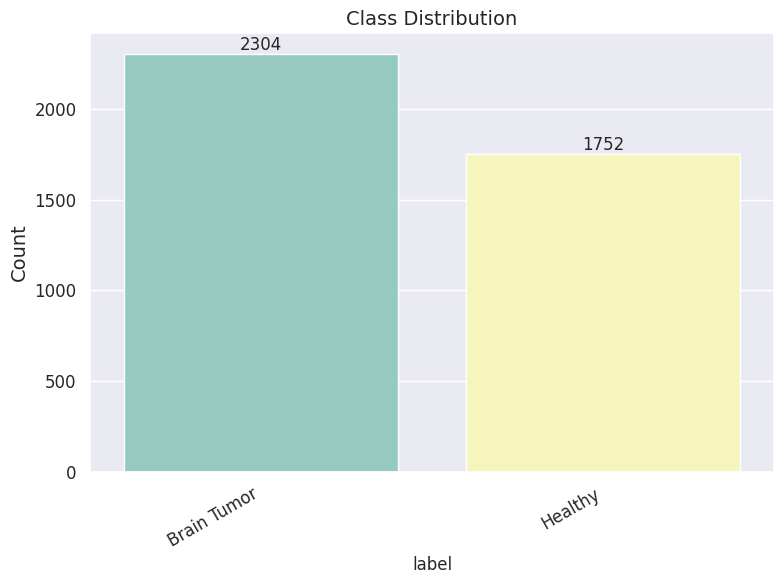

In [17]:
plt.figure(figsize=(8, 6))  

ax = sns.countplot(data=df, x='label', palette='Set3')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"
    )


plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=14)

plt.tight_layout()
plt.show()

### Check for Corrupted Files

In [ ]:
def find_corrupted_images(df): 
    corrupted = [] 

    for row in df.itertuples(): 
        image_path = row.image_path 
        try:
            img = Image.open(image_path) 
            img.verify() 
        except Exception as e:
            corrupted.append((image_path, str(e))) 

    df_corrupted = pd.DataFrame(corrupted, columns=["Image Path", "Error"]) 
    print(f"✅ Found {len(df_corrupted)} corrupted images") 
    return df_corrupted


df_corrupted = find_corrupted_images(df) 

if not df_corrupted.empty: 
    print(df_corrupted.head())
else: 
    print("No corrupted images found 🚀")

✅ Found 0 corrupted images
No corrupted images found 🚀


Visualize Sample Images from Each Class

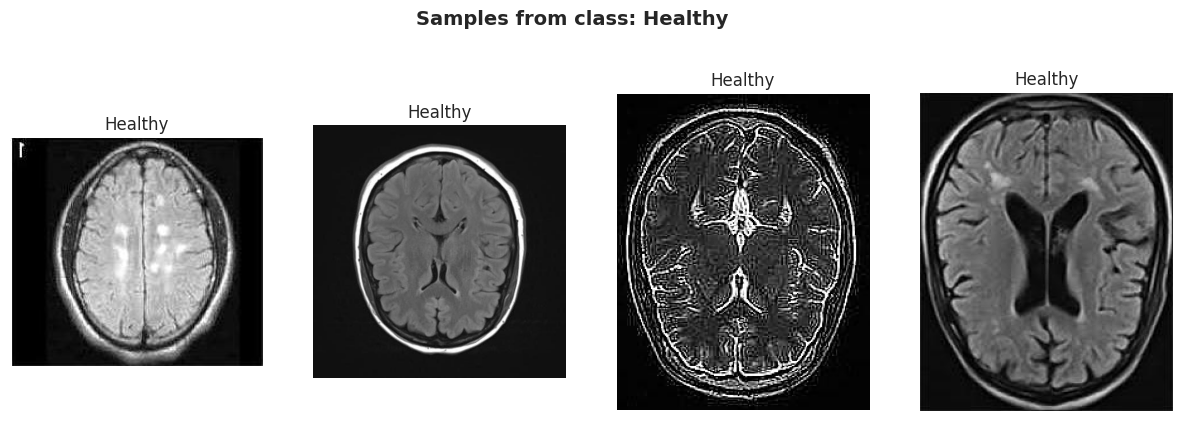

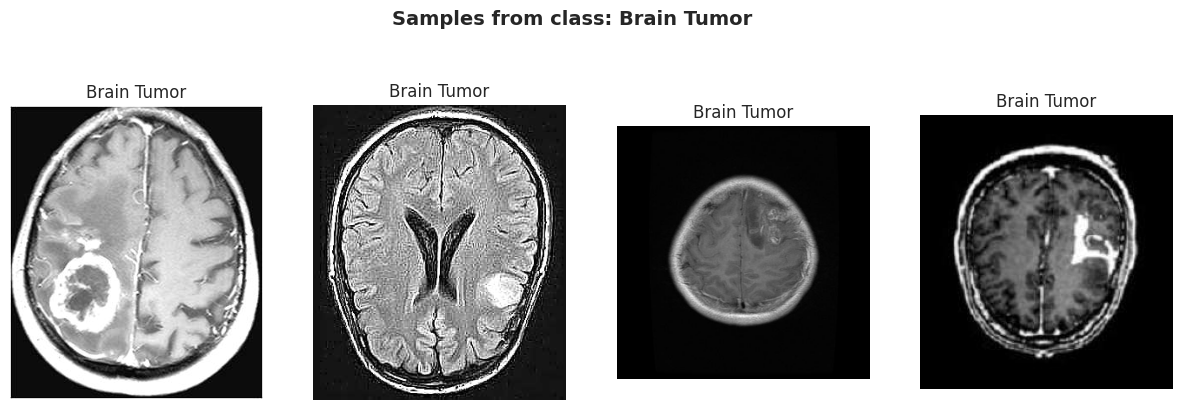

In [ ]:
def show_class_samples(df, class_name, n_samples=4): 
    """Display n_samples images from a given class."""
    sample_df = df[df["label"] == class_name].sample(n_samples)
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    fig.suptitle(f"Samples from class: {class_name}", fontsize=14, fontweight="bold")

    for i, row in enumerate(sample_df.itertuples()):
        img = Image.open(row.image_path).convert("L") 
        axes[i].imshow(img, cmap="gray") 
        axes[i].set_title(class_name) 
        axes[i].axis("off")

    plt.show()


show_class_samples(df, "Healthy", n_samples=4) 
show_class_samples(df, "Brain Tumor", n_samples=4)

Splitting Data into Training and Testing Sets

In [ ]:
df_train, df_test = train_test_split(
    df, 
    test_size=0.1, 
    stratify=df["label"],
    random_state=42
)

df_train, df_val = train_test_split(
    df_train, 
    test_size=0.1, 
    stratify=df_train["label"],
    random_state=42
)
print("Train size:", len(df_train)) 
print("Val size:", len(df_val))
print("Test size:", len(df_test))

Train size: 3285
Val size: 365
Test size: 406


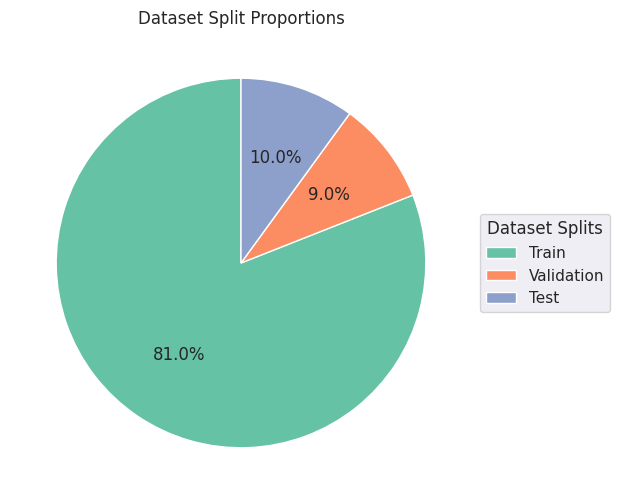

In [ ]:
split_counts = {
    "Train": len(df_train),
    "Validation": len(df_val),
    "Test": len(df_test)
}

labels = list(split_counts.keys()) 
sizes = list(split_counts.values()) 

colors = plt.cm.Set2.colors[:len(labels)]


plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors
)
plt.legend(
    wedges, labels, 
    title="Dataset Splits", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Dataset Split Proportions")
plt.show()

In [ ]:
df_splits = pd.DataFrame(list(split_counts.items()), columns=["Split", "Count"])
df_splits

Split  Count
0       Train   3285
1  Validation    365
2        Test    406

In [ ]:
print(df["label"].value_counts(normalize=True).mul(100).round(2))
print("="*100)
print(df_train["label"].value_counts(normalize=True).mul(100).round(2))
print("="*100)
print(df_val["label"].value_counts(normalize=True).mul(100).round(2))
print("="*100)
print(df_test["label"].value_counts(normalize=True).mul(100).round(2))
print("="*100)

label
Brain Tumor    56.8
Healthy        43.2
Name: proportion, dtype: float64
label
Brain Tumor    56.8
Healthy        43.2
Name: proportion, dtype: float64
label
Brain Tumor    56.71
Healthy        43.29
Name: proportion, dtype: float64
label
Brain Tumor    56.9
Healthy        43.1
Name: proportion, dtype: float64


In [ ]:
df_train['label'].value_counts()

label
Brain Tumor    1866
Healthy        1419
Name: count, dtype: int64

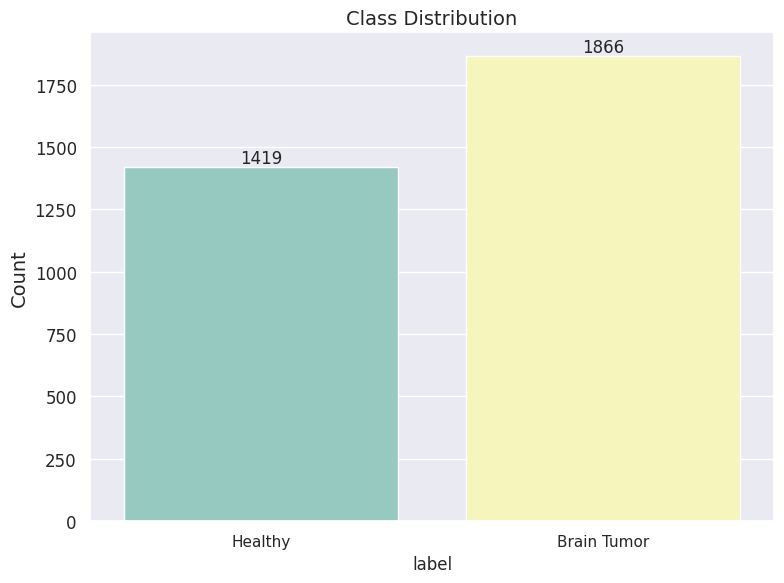

In [ ]:
plt.figure(figsize=(8, 6))  

ax = sns.countplot(data=df_train, x='label', palette='Set3')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"
    )


plt.yticks(fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
df_val['label'].value_counts()

label
Brain Tumor    207
Healthy        158
Name: count, dtype: int64

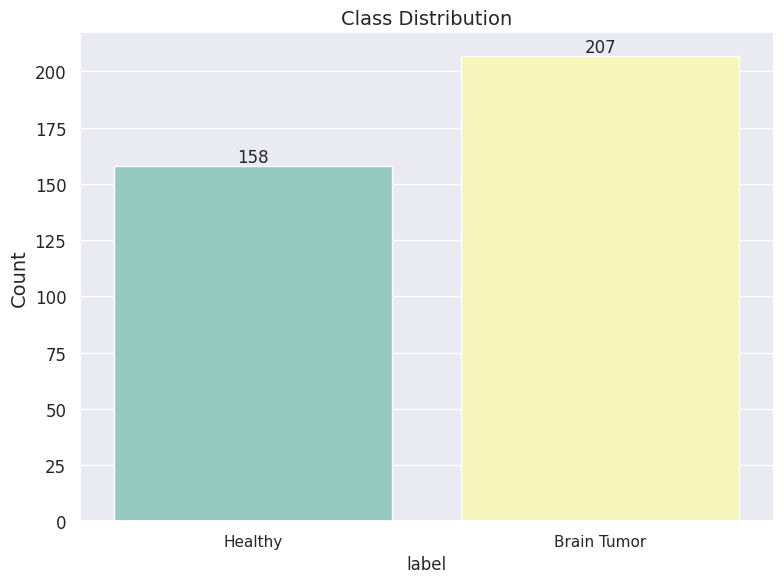

In [27]:
plt.figure(figsize=(8, 6))  

ax = sns.countplot(data=df_val, x='label', palette='Set3')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"
    )


plt.yticks(fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
df_test['label'].value_counts()

label
Brain Tumor    231
Healthy        175
Name: count, dtype: int64

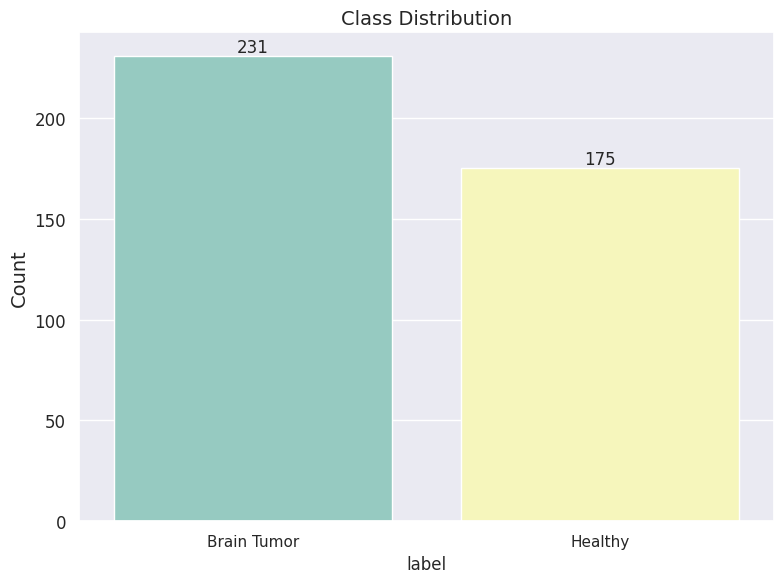

In [29]:
plt.figure(figsize=(8, 6))  

ax = sns.countplot(data=df_test, x='label', palette='Set3')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"
    )


plt.yticks(fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=14)

plt.tight_layout()
plt.show()

Image Data Augmentation and Visualization

In [ ]:
IMG_SIZE = (299, 299) 
BATCH_SIZE = 32 

train_image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=1,           
    width_shift_range=0.01,        
    height_shift_range=0.01,                   
    zoom_range=0.1,               
    fill_mode="nearest"
)

val_test_image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path", 
    y_col="label", 
    target_size=IMG_SIZE,
    color_mode="rgb",           
    class_mode="binary", 
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=42
)
val_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH_SIZE
)


test_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH_SIZE
)

Found 3285 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.
Found 406 validated image filenames belonging to 2 classes.


In [ ]:
print("Train class indices:", train_generator.class_indices)
print("Val class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Train class indices: {'Brain Tumor': 0, 'Healthy': 1}
Val class indices: {'Brain Tumor': 0, 'Healthy': 1}
Test class indices: {'Brain Tumor': 0, 'Healthy': 1}


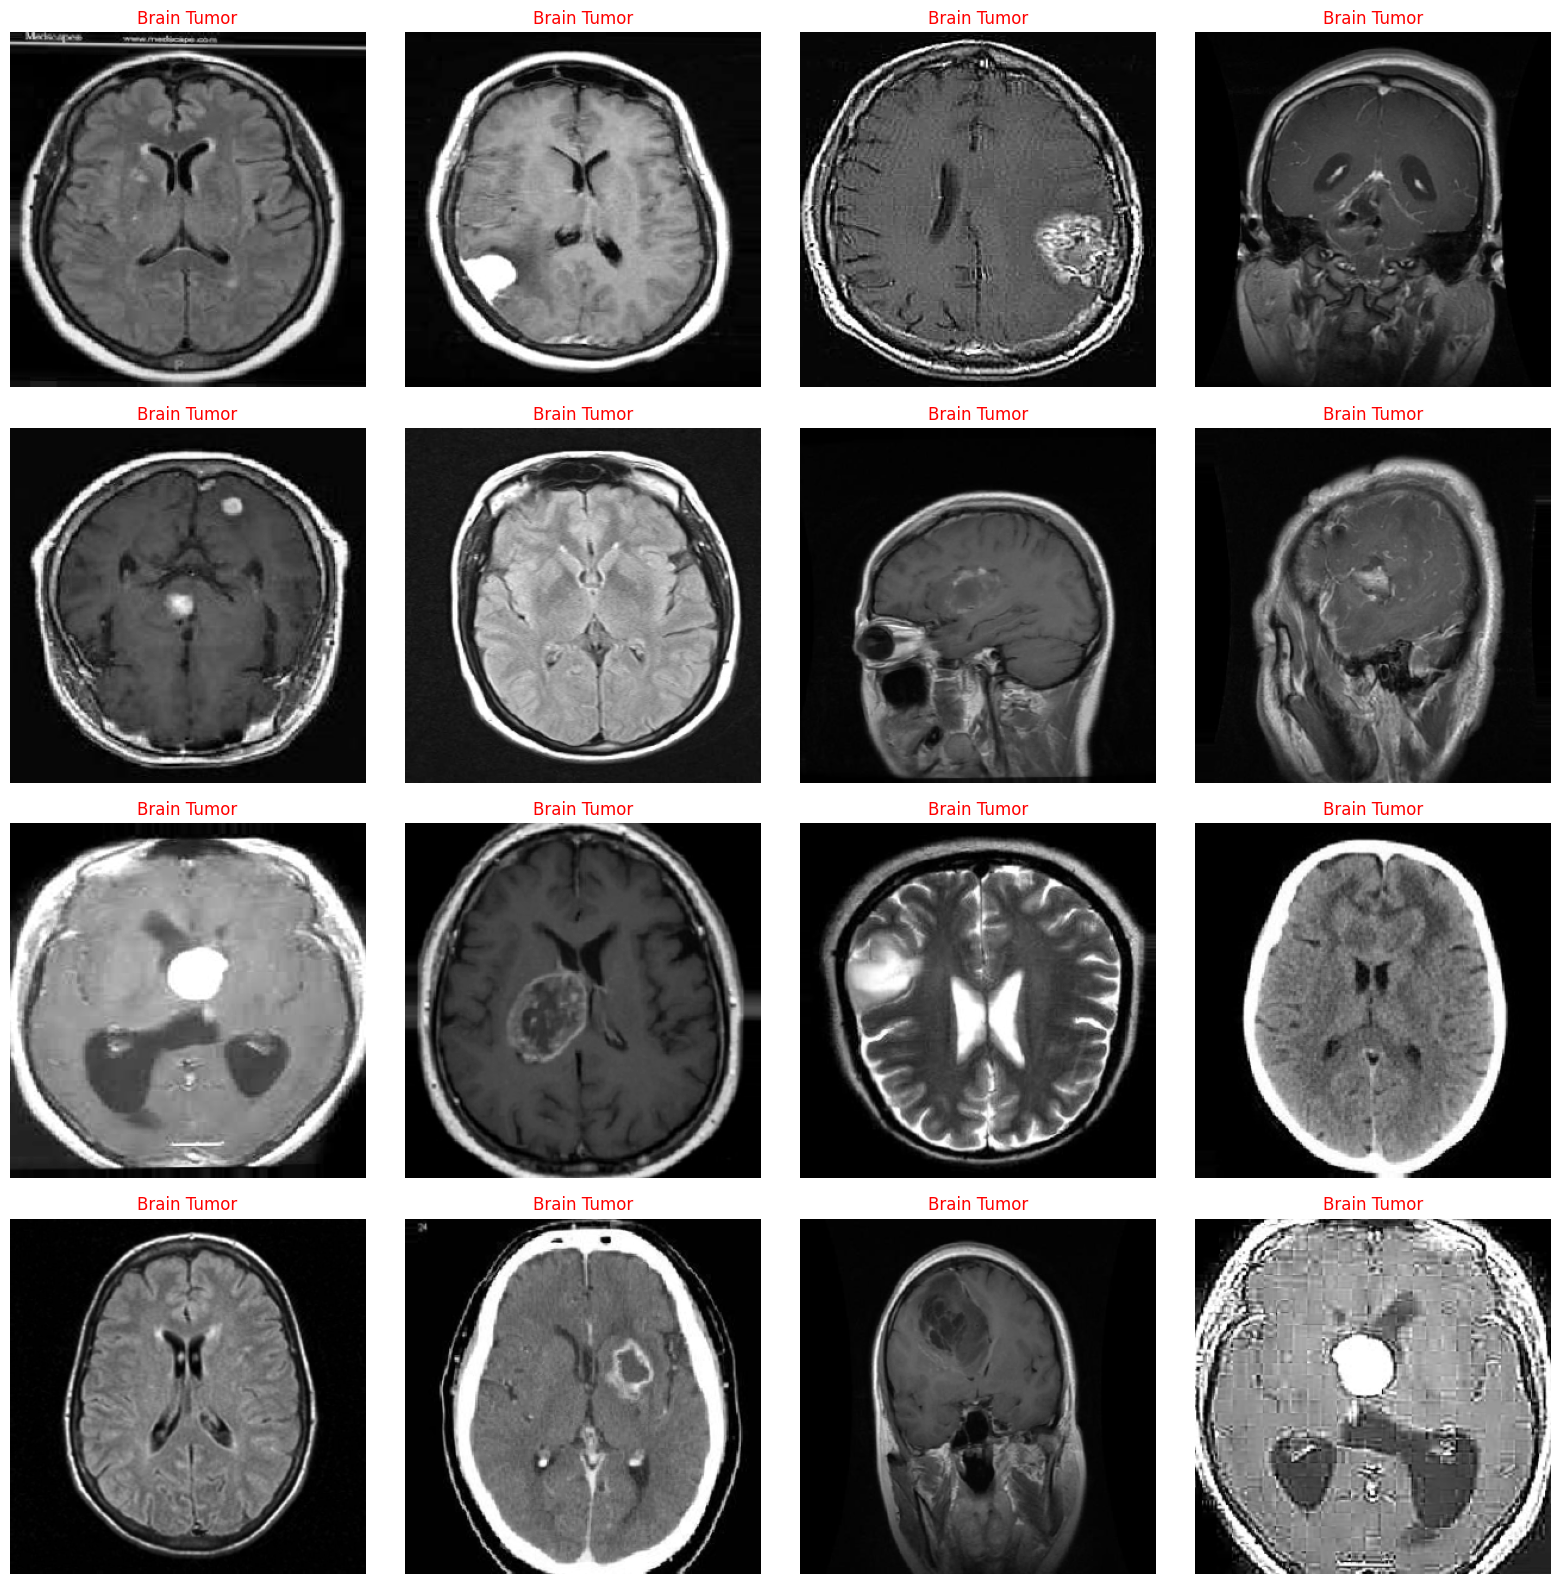

In [ ]:
images, labels = next(train_generator)

class_indices = train_generator.class_indices 
classes = list(class_indices.keys()) 

plt.figure(figsize=(16, 16))
for i in range(16): 
    plt.subplot(4, 4, i + 1) 

    image = images[i][:, :, 0]
    plt.imshow(image, cmap="gray")

    index = np.argmax(labels[i])
    class_name = classes[index]

    plt.title(class_name, color="red", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Training InceptionV3 for Brain Tumor MRI Classification**

### **About InceptionV3**
- **InceptionV3** is a deep convolutional neural network known for its **Inception modules**, which combine multiple convolutional filter sizes in parallel.
This architecture helps the model capture both **fine details** and **global patterns** efficiently.
- It is pretrained on **ImageNet**, enabling strong **feature extraction** for transfer learning.
- By setting `include_top=False`, we remove the original classification layer and add a **custom dense head** with sigmoid activation for our **binary classification task**:
    - Brain Tumor
    - Healthy

### **Why Transfer Learning with InceptionV3?**
- Training a CNN from scratch on medical MRI scans requires very large datasets and computational power.
- **Transfer learning** leverages the pretrained knowledge of InceptionV3 (trained on millions of natural images) and adapts it to the **domain of brain MRI scans**.
- This approach:
    - Enhances **accuracy** even with limited medical datasets
    - Improves **generalization** to unseen MRI scans
    - Reduces **training time and resource requirements**
  
In this project, InceptionV3 acts as a **robust feature extractor**, while the added custom layers specialize the model for detecting **Brain Tumors in MRI images**.

In [ ]:
IMG_SIZE = (299, 299) 
CHANNELS = 3 
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS) 


base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    pooling="max"   
)

model = Sequential([
    base_model, 
    BatchNormalization(), 
    Dense(256, 
          activation="relu", 
          kernel_regularizer=regularizers.l2(0.001), 
          activity_regularizer=regularizers.l1(0.0001), 
          bias_regularizer=regularizers.l1(0.00001)),
    Dropout(0.45, seed=42), 
    Dense(1, activation="sigmoid") 
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="binary_crossentropy",  
    metrics=["accuracy"]
)
model.summary()

I0000 00:00:1759347765.681143      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759347765.681873      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,335,777 (85.20 MB)

 Trainable params: 22,297,249 (85.06 MB)

 Non-trainable params: 38,528 (150.50 KB)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "best_inceptionv3.h5",       
    monitor="val_accuracy",      
    save_best_only=True,
    mode="max", # because we want the validation accuracy to increase
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [35]:
EPOCHS = 3
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/3


I0000 00:00:1759347825.671543     109 service.cc:148] XLA service 0x78ec600c1270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759347825.672450     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759347825.672471     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759347830.927352     109 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759347870.877579     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8165 - loss: 1.3397
Epoch 1: val_accuracy improved from -inf to 0.91507, saving model to best_inceptionv3.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.8172 - loss: 1.3372 - val_accuracy: 0.9151 - val_loss: 1.0058 - learning_rate: 0.0010
Epoch 2/3
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.9780 - loss: 0.7010
Epoch 2: val_accuracy improved from 0.91507 to 0.95616, saving model to best_inceptionv3.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 79s 767ms/step - accuracy: 0.9779 - loss: 0.7007 - val_accuracy: 0.9562 - val_loss: 0.7277 - learning_rate: 0.0010
Epoch 3/3
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.9941 - loss: 0.5827
Epoch 3: val_accuracy improved from 0.95616 to 0.97534, saving model to best_inceptionv3.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 78s 755ms/step - accuracy: 0.9941 - loss: 0.5826 - val_accuracy: 0.9753 - val_loss: 0.5869 - learning_rate: 0.0010
Restoring model weights from the end of the best 

Model Evaluation

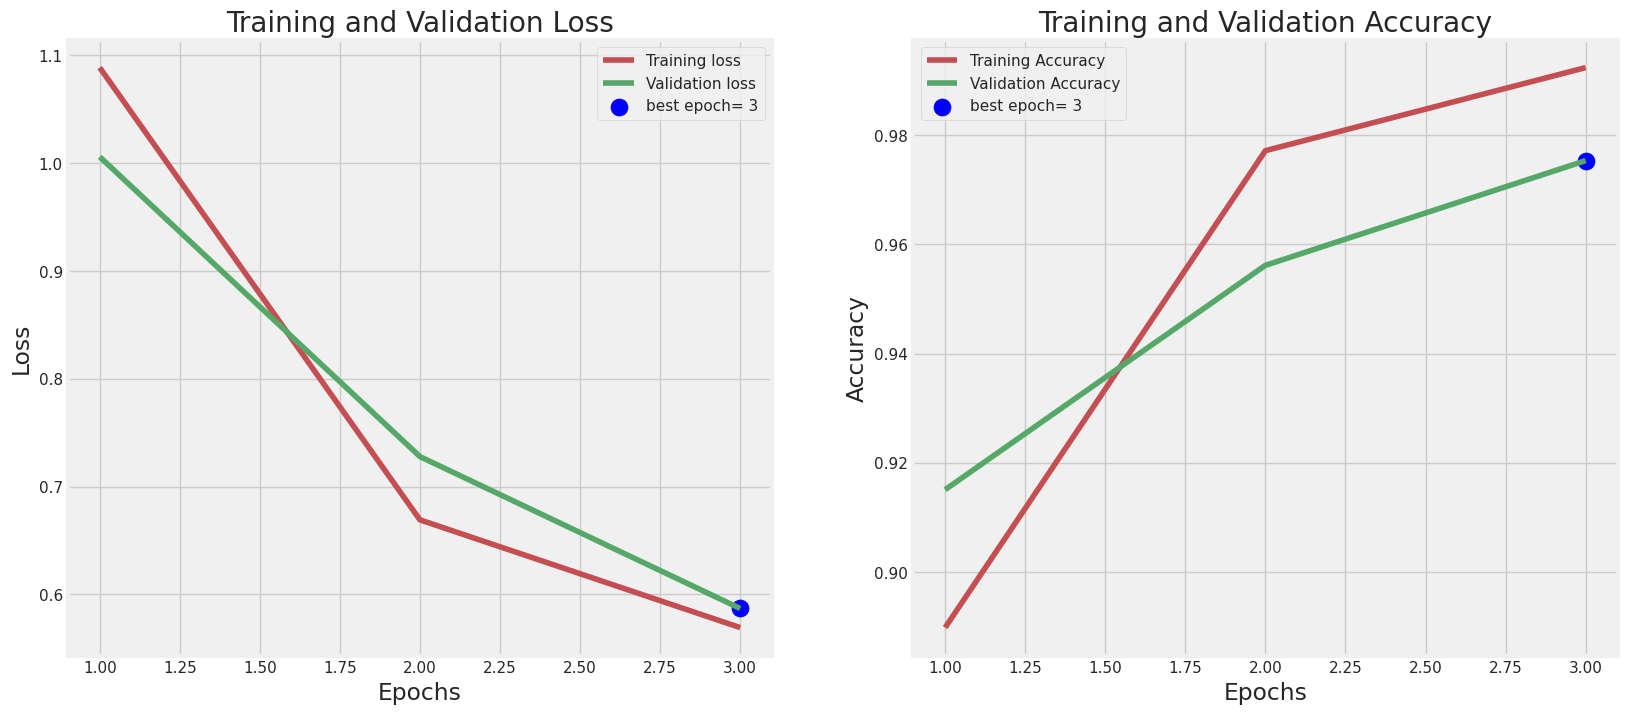

In [36]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_generator, verbose= 1) 
valid_score = model.evaluate(val_generator, verbose= 1)
test_score = model.evaluate(test_generator, verbose= 1)

print("\nTrain Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

103/103 ━━━━━━━━━━━━━━━━━━━━ 72s 696ms/step - accuracy: 0.9956 - loss: 0.5480
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9718 - loss: 0.5894
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 873ms/step - accuracy: 0.9750 - loss: 0.6009

Train Loss:  0.5483121871948242
Train Accuracy:  0.9963470101356506
--------------------
Validation Loss:  0.5868764519691467
Validation Accuracy:  0.9753424525260925
--------------------
Test Loss:  0.5865461826324463
Test Accuracy:  0.982758641242981


In [ ]:
y_pred_prob = model.predict(test_generator)
y_pred_prob

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 687ms/step


array([[0.9024053 ],
       [0.06914301],
       [0.04007312],
       [0.99782515],
       [0.99804115],
       [0.98510146],
       [0.99965453],
       [0.9913066 ],
       [0.01758547],
       [0.00615302],
       [0.9978816 ],
       [0.02026077],
       [0.00488311],
       [0.01610959],
       [0.9959337 ],
       [0.9737457 ],
       [0.22230005],
       [0.988467  ],
       [0.00557416],
       [0.9960232 ],
       [0.01190684],
       [0.01237336],
       [0.01024672],
       [0.91787297],
       [0.98084223],
       [0.00708292],
       [0.01426278],
       [0.01402985],
       [0.01880923],
       [0.00824054],
       [0.98833233],
       [0.9942462 ],
       [0.03937899],
       [0.00716603],
       [0.01200046],
       [0.983383  ],
       [0.9962697 ],
       [0.006384  ],
       [0.01249076],
       [0.01416214],
       [0.01386425],
       [0.01060218],
       [0.01613635],
       [0.01203077],
       [0.998698  ],
       [0.00792515],
       [0.01106313],
       [0.010

In [39]:
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()
y_pred
# this means that if the prediction for the image is greater than 0.5 so this means that this image belongs to class 1(Healthy class) and if the prediction for the image was less than 0.5 this means that this image will belong to class 0(Brain Tumor class)

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,

In [ ]:
y_true = test_generator.classes
y_true

[0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,


In [41]:
CM = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", CM)

Confusion Matrix:
 [[228   3]
 [  4 171]]


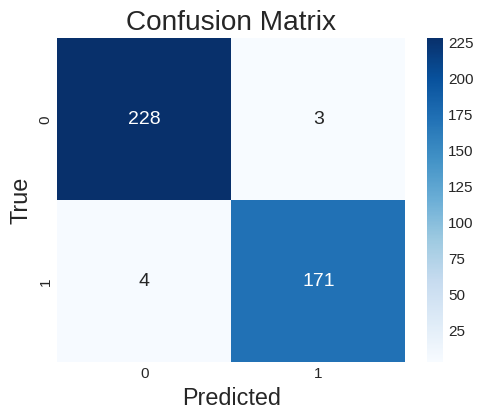

In [42]:
plt.style.use("seaborn-white")
plt.figure(figsize=(5,4))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix")
plt.show()

In [43]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


Classification Report:
              precision    recall  f1-score   support

 Brain Tumor       0.98      0.99      0.98       231
     Healthy       0.98      0.98      0.98       175

    accuracy                           0.98       406
   macro avg       0.98      0.98      0.98       406
weighted avg       0.98      0.98      0.98       406



In [45]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9828
Precision: 0.9828
Recall:    0.9771
F1 Score:  0.9799


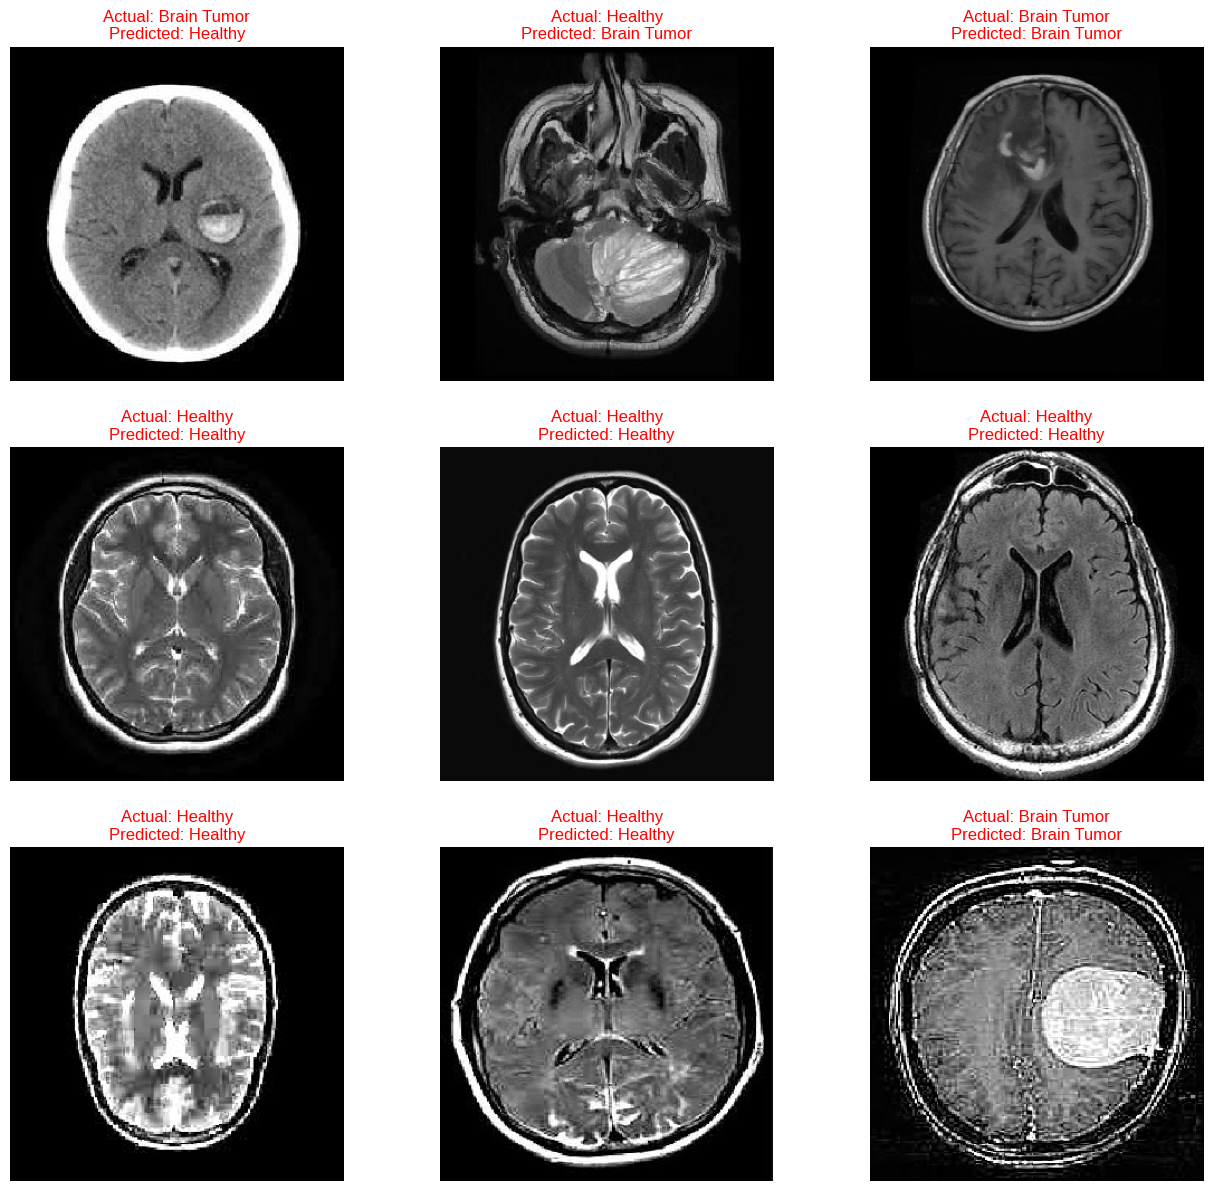

In [ ]:
images, labels = next(test_generator) 

class_indices = test_generator.class_indices 
idx_to_class = {v: k for k, v in class_indices.items()} # 

plt.figure(figsize=(14, 14))

for i in range(9): 
    image = images[i] 
    true_label_idx = int(labels[i]) 
    true_label_name = idx_to_class[true_label_idx] 

    pred = model.predict(np.expand_dims(image, axis=0), verbose=0) 
    predicted_idx = int(pred[0][0] > 0.5)  
    predicted_class = idx_to_class[predicted_idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image[..., 0], cmap="gray") 
    plt.title(f"Actual: {true_label_name}\nPredicted: {predicted_class}", fontsize=12, color="red")
    plt.axis("off")

plt.show()

### Authenticate with Hugging Face Hub

In [58]:
load_dotenv()
token = os.getenv("HUGGINGFACE_TOKEN")
login(token=token)

In [ ]:
api = HfApi()

repo_id = "Eyaddddddd/BrainTumorClassifier"

api.create_repo(repo_id=repo_id, repo_type="model", private=True, exist_ok=True)

print(f"✅ Repo created: https://huggingface.co/{repo_id}")

local_model_path = "/kaggle/working/best_inceptionv3.h5"

api.upload_file(
    path_or_fileobj=local_model_path,
    path_in_repo="BrainTumorClassifier.h5",   
    repo_id=repo_id,
    repo_type="model"
)
print(f"✅ Model uploaded to: https://huggingface.co/{repo_id}/blob/main/BrainTumorClassifier.h5")

✅ Repo created: https://huggingface.co/Eyaddddddd/BrainTumorClassifier


Uploading...:   0%|          | 0.00/269M [00:00<?, ?B/s]

✅ Model uploaded to: https://huggingface.co/Eyaddddddd/BrainTumorClassifier/blob/main/BrainTumorClassifier.h5


In [60]:
model_path = hf_hub_download(
    repo_id="Eyaddddddd/BrainTumorClassifier", 
    filename="BrainTumorClassifier.h5"  
)

model = load_model(model_path)
print("✅ Model loaded from Hugging Face:", model_path)

BrainTumorClassifier.h5:   0%|          | 0.00/269M [00:00<?, ?B/s]

✅ Model loaded from Hugging Face: /root/.cache/huggingface/hub/models--Eyaddddddd--BrainTumorClassifier/snapshots/5ebb48745da9e7da3dd97252c44c8820175dc1c6/BrainTumorClassifier.h5


In [ ]:
class_mapping = {
    "Brain Tumor": 0,
    "Healthy": 1
}

def preprocess_image(image_path):
    IMG_SIZE = (299, 299)  
    image = Image.open(image_path).convert("RGB") 
    image = image.resize(IMG_SIZE) 
    img_array = np.array(image)
    img_array = preprocess_input(img_array) 
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def predict_and_show(image_path):
    img_array = preprocess_image(image_path)

    prediction = model.predict(img_array, verbose=0)[0][0] 

    predicted_idx = 1 if prediction >= 0.5 else 0
    probability = prediction if predicted_idx == 1 else 1 - prediction

    idx_to_class = {v: k for k, v in class_mapping.items()}
    predicted_class = idx_to_class[predicted_idx]

    messages = {
        "Healthy": "✅ Likely Healthy brain (no tumor detected)",
        "Brain Tumor": "⚠️ Signs of Brain Tumor detected"
    }
    message = messages.get(predicted_class, "ℹ️ Prediction result")

    plt.imshow(Image.open(image_path).convert("RGB"))
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class} ({probability:.2f})", fontsize=12)
    plt.show()

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {probability:.2f}")
    print(message)

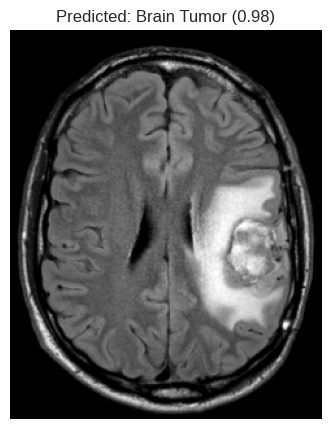

Predicted Class: Brain Tumor
Confidence: 0.98
⚠️ Signs of Brain Tumor detected


In [ ]:
predict_and_show("Brain Tumor.jpg") 

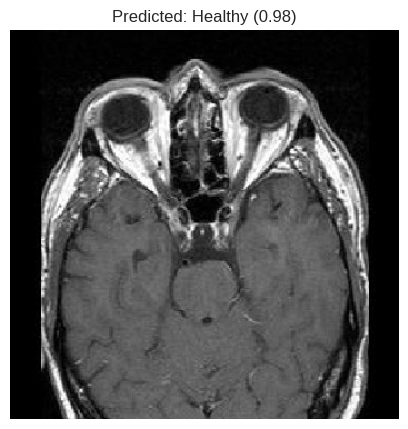

Predicted Class: Healthy
Confidence: 0.98
✅ Likely Healthy brain (no tumor detected)


In [65]:
predict_and_show("Healthy.jpg")

**Thank you for exploring the BrainTumorClassifier project.**